# Step 1. Initialize environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Step 2. Import codes for training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc_units=[256,128,64]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(QNetwork, self).__init__()
        self.fc1=nn.Linear(state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.prob = nn.LogSoftmax(dim=1)

    def forward(self, state, alpha):
        """Build a network that maps state -> action values, probabilities and state values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        log_probs = self.prob(x/alpha)
        Z = x/alpha + log_probs
        maximum = Z.max(dim=1, keepdim=True)[0]
        V = alpha*(maximum + (Z-maximum).exp().sum(dim=1, keepdim=True).log())
        return x, log_probs, V

In [5]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
ALPHA = 1               # Bonus for entropy reward

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, alpha=ALPHA, learning_rate=LR, gamma=GAMMA, tau=TAU):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            lr (float): learning rate for local network
            tau (float): learning rate for target network
            gamma (float): decay rate for future rewards
            prioritized (bollean): decide whether to use prioritized Q-Learning
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.tau = tau
        self.gamma = gamma
        self.alpha = alpha
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # Networks
        self.qnetwork_local = QNetwork(state_size, action_size)
        self.qnetwork_target = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1)

    def act(self, state):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
        """
        state = torch.tensor(state, dtype=torch.float32).to(device).view(1,-1)
        _, log_probs, _ = self.qnetwork_local(state, self.alpha)
        log_probs = log_probs.detach().view(-1).numpy()
        action = np.random.choice(self.action_size, size=1, replace=False, p=np.exp(log_probs))
        return action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones= experiences
        
        Q_local, _, _ = self.qnetwork_local(states, self.alpha)
        Q_local = Q_local.gather(1, actions)
        _, _, V_target = self.qnetwork_target(next_states, self.alpha)
        Q_target = rewards + (1-dones)*self.gamma*V_target.detach()
        loss = 0.5*(Q_local - Q_target).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 5)
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory.
        
        Params
        ======
            priority: a vector records the priority for each experience
            alpha: to determine how much the priority should influence the probability. 
                p(sample i) ~ priority(sample i)**alpha
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        #Extract information from memory unit and return
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
from collections import deque

def Discrete_SQN(n_episodes, max_t, agent, UPDATE):
    """
    Monitor the training process
    Params
    ======
        env, brain_name and agent are assumed to be defined elsewhere
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        finish (boolean): if True, the function finish n_episodes and return a smooth
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    means=[]
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.memory.add(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if t % UPDATE == 0:
                if len(agent.memory) > BATCH_SIZE:
                    experience = agent.memory.sample()
                    agent.learn(experience)
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window),), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
        means.append(np.mean(scores_window))
        
    #torch.save(agent.qnetwork_local.state_dict(), 'SQN_checkpoint.pth')
    return scores, means

# Step 3. Train the agent and see the result

In [7]:
import matplotlib.pyplot as plt

def plot_result(scores, means, suptitle=''):
    fig = plt.figure(figsize=(20,10))
    if suptitle is not '':
        fig.suptitle(suptitle)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    average = np.mean(means, axis=0)
    error_bar = np.std(means, axis=0)/np.sqrt(15)
    upper = np.amax(means, axis=0)
    lower = np.amin(means, axis=0)
    ax1.plot(range(1000), average, label='Trajectory of moving average', color='yellow')
    ax1.plot(range(1000), upper, label='Upper bound', color='black')
    ax1.plot(range(1000), lower, label='Lower bound', color='black')
    ax1.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax1.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax1.set_ylabel('Average')
    ax1.set_xlabel('Episode #')
    ax1.legend(loc=1)
    ax1.set_ylim([0, 20])
    ax1.set_title('Trajectory for moving average')
    
    average = np.mean(scores, axis=0)
    error_bar = np.std(scores, axis=0)/np.sqrt(15)
    upper = np.amax(scores, axis=0)
    lower = np.amin(scores, axis=0)
    ax2.plot(range(1000), average, label='Trajectory of episodic scores', color='yellow')
    ax2.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax2.plot(range(1000), upper, label='Upper bound', color='black')
    ax2.plot(range(1000), lower, label='Lower bound', color='black')
    ax2.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Episode #')
    ax2.legend(loc=1)
    ax2.set_ylim([0, 30])
    ax2.set_title('Trajectory for episodic rewards')
    
    plt.show()

## $\alpha=0.005$

In [11]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.005, learning_rate=0.0001)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 7.00	Average Score: 3.68
Episode 200	Episodic Score: 14.00	Average Score: 9.47
Episode 300	Episodic Score: 15.00	Average Score: 12.73
Episode 400	Episodic Score: 17.00	Average Score: 14.14
Episode 500	Episodic Score: 18.00	Average Score: 15.35
Episode 600	Episodic Score: 23.00	Average Score: 16.89
Episode 700	Episodic Score: 18.00	Average Score: 16.18
Episode 800	Episodic Score: 13.00	Average Score: 17.31
Episode 900	Episodic Score: 19.00	Average Score: 17.11
Episode 1000	Episodic Score: 12.00	Average Score: 16.98
Test No.2:
Episode 100	Episodic Score: -1.00	Average Score: -0.13
Episode 200	Episodic Score: 0.00	Average Score: 0.0322
Episode 300	Episodic Score: 1.00	Average Score: 0.0541
Episode 400	Episodic Score: -4.00	Average Score: -0.06
Episode 500	Episodic Score: 0.00	Average Score: 0.0732
Episode 600	Episodic Score: 0.00	Average Score: 0.066
Episode 700	Episodic Score: 0.00	Average Score: 0.1665
Episode 800	Episodic Score: 0.00	Average Score

Episode 700	Episodic Score: 22.00	Average Score: 17.22
Episode 800	Episodic Score: 17.00	Average Score: 17.03
Episode 900	Episodic Score: 13.00	Average Score: 17.37
Episode 1000	Episodic Score: 21.00	Average Score: 17.40


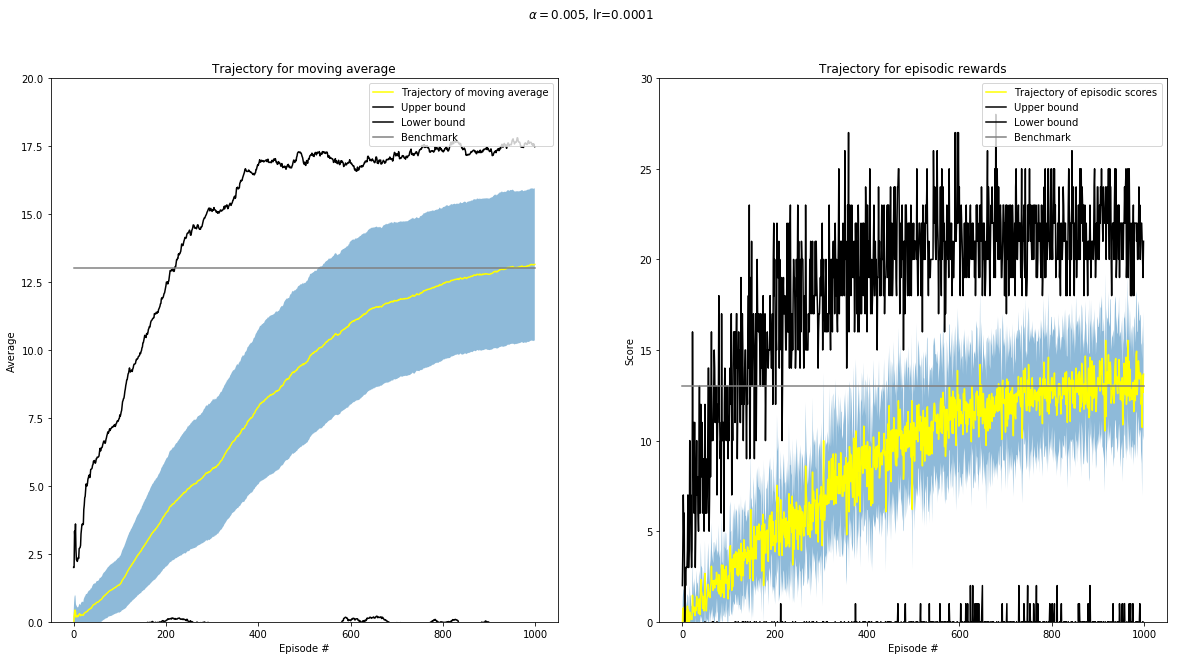

In [12]:
plot_result(scores, means, r'$\alpha=0.005$, lr=0.0001')

In [14]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.005, learning_rate=0.0005)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 4.00	Average Score: 5.46
Episode 200	Episodic Score: 9.00	Average Score: 10.446
Episode 300	Episodic Score: 18.00	Average Score: 15.22
Episode 400	Episodic Score: 22.00	Average Score: 15.48
Episode 500	Episodic Score: 15.00	Average Score: 15.11
Episode 600	Episodic Score: 14.00	Average Score: 15.32
Episode 700	Episodic Score: 17.00	Average Score: 15.84
Episode 800	Episodic Score: 21.00	Average Score: 14.93
Episode 900	Episodic Score: 14.00	Average Score: 14.94
Episode 1000	Episodic Score: 15.00	Average Score: 14.53
Test No.2:
Episode 100	Episodic Score: 5.00	Average Score: 2.397
Episode 200	Episodic Score: 10.00	Average Score: 5.65
Episode 300	Episodic Score: 14.00	Average Score: 9.62
Episode 400	Episodic Score: 17.00	Average Score: 12.97
Episode 500	Episodic Score: 13.00	Average Score: 13.43
Episode 600	Episodic Score: 14.00	Average Score: 14.91
Episode 700	Episodic Score: 17.00	Average Score: 15.62
Episode 800	Episodic Score: 12.00	Average Score

Episode 700	Episodic Score: 13.00	Average Score: 15.29
Episode 800	Episodic Score: 17.00	Average Score: 14.72
Episode 900	Episodic Score: 13.00	Average Score: 14.35
Episode 1000	Episodic Score: 15.00	Average Score: 14.62


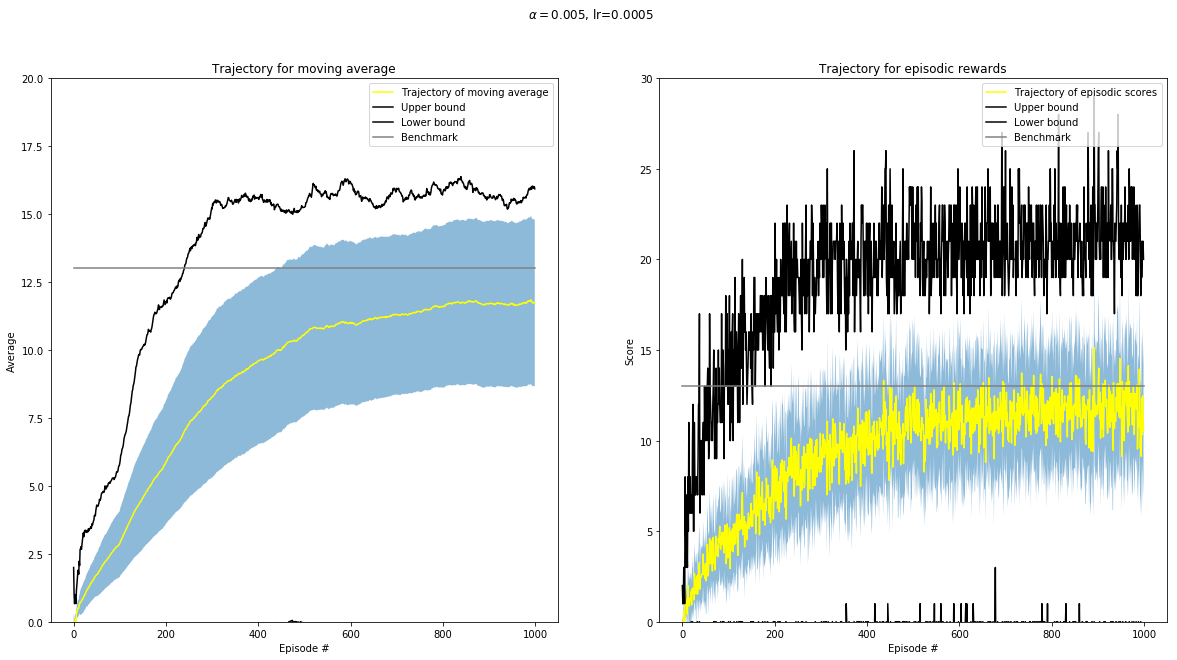

In [15]:
plot_result(scores, means, r'$\alpha=0.005$, lr=0.0005')

## $\alpha=0.01$

In [26]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.01, learning_rate=0.0001)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 2.00	Average Score: 1.65
Episode 200	Episodic Score: 12.00	Average Score: 6.57
Episode 300	Episodic Score: 11.00	Average Score: 12.05
Episode 400	Episodic Score: 18.00	Average Score: 13.01
Episode 500	Episodic Score: 17.00	Average Score: 15.74
Episode 600	Episodic Score: 18.00	Average Score: 16.86
Episode 700	Episodic Score: 21.00	Average Score: 16.51
Episode 800	Episodic Score: 14.00	Average Score: 16.53
Episode 900	Episodic Score: 14.00	Average Score: 16.54
Episode 1000	Episodic Score: 25.00	Average Score: 17.14
Test No.2:
Episode 100	Episodic Score: 0.00	Average Score: -0.26
Episode 200	Episodic Score: -1.00	Average Score: -0.46
Episode 300	Episodic Score: -2.00	Average Score: -0.55
Episode 400	Episodic Score: 1.00	Average Score: -0.020
Episode 500	Episodic Score: -1.00	Average Score: -0.03
Episode 600	Episodic Score: 3.00	Average Score: -0.226
Episode 700	Episodic Score: -2.00	Average Score: 0.011
Episode 800	Episodic Score: -3.00	Average Scor

Episode 700	Episodic Score: 9.00	Average Score: 15.950
Episode 800	Episodic Score: 18.00	Average Score: 15.83
Episode 900	Episodic Score: 15.00	Average Score: 16.26
Episode 1000	Episodic Score: 16.00	Average Score: 16.45


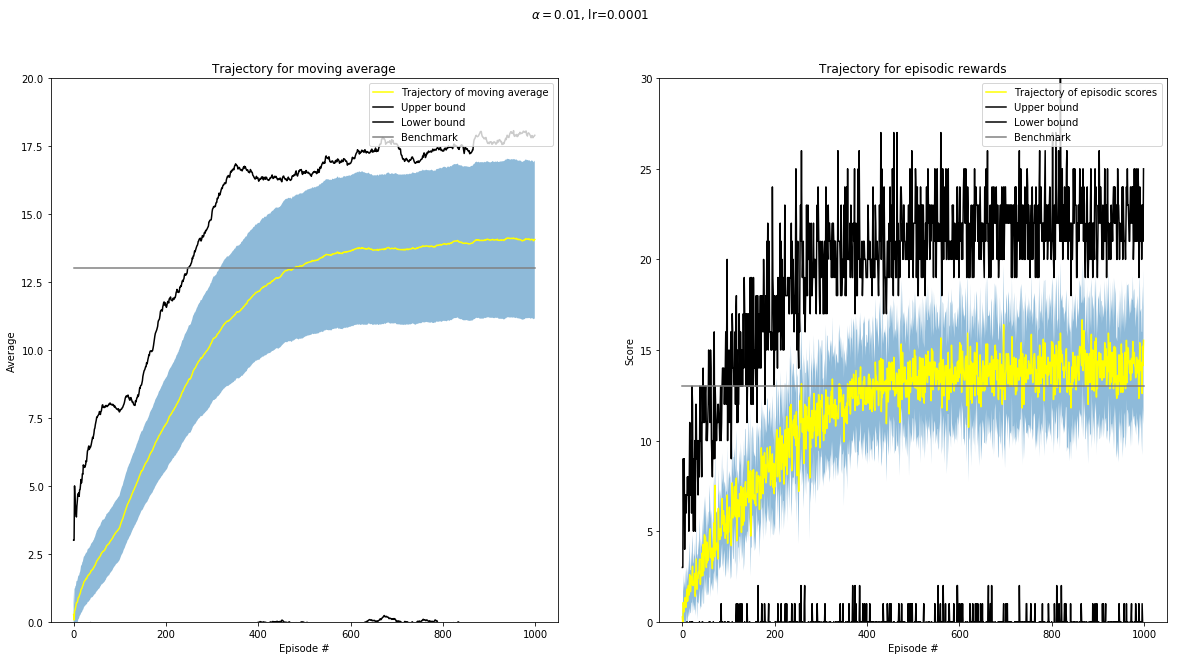

In [27]:
plot_result(scores, means, r'$\alpha=0.01$, lr=0.0001')

In [20]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.01, learning_rate=0.0005)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 3.00	Average Score: 2.26
Episode 200	Episodic Score: 11.00	Average Score: 9.64
Episode 300	Episodic Score: 10.00	Average Score: 12.08
Episode 400	Episodic Score: 10.00	Average Score: 14.61
Episode 500	Episodic Score: 13.00	Average Score: 14.58
Episode 600	Episodic Score: 17.00	Average Score: 14.93
Episode 700	Episodic Score: 12.00	Average Score: 15.47
Episode 800	Episodic Score: 14.00	Average Score: 15.83
Episode 900	Episodic Score: 18.00	Average Score: 15.20
Episode 1000	Episodic Score: 12.00	Average Score: 14.12
Test No.2:
Episode 100	Episodic Score: 5.00	Average Score: 3.47
Episode 200	Episodic Score: 9.00	Average Score: 10.040
Episode 300	Episodic Score: 9.00	Average Score: 12.944
Episode 400	Episodic Score: 13.00	Average Score: 14.46
Episode 500	Episodic Score: 15.00	Average Score: 15.63
Episode 600	Episodic Score: 15.00	Average Score: 16.36
Episode 700	Episodic Score: 12.00	Average Score: 15.56
Episode 800	Episodic Score: 9.00	Average Score:

Episode 700	Episodic Score: 19.00	Average Score: 15.73
Episode 800	Episodic Score: 15.00	Average Score: 15.74
Episode 900	Episodic Score: 14.00	Average Score: 14.85
Episode 1000	Episodic Score: 12.00	Average Score: 15.94


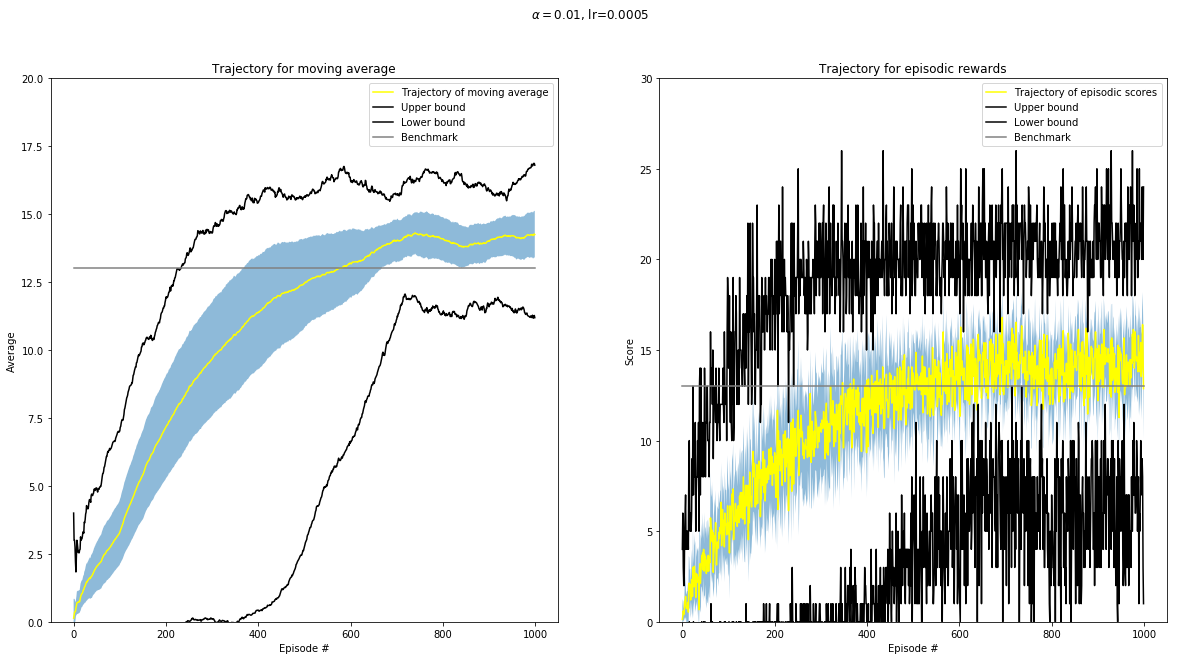

In [24]:
plot_result(scores, means, r'$\alpha=0.01$, lr=0.0005')

In [18]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.01, learning_rate=0.001)
    scores1[i,:], means1[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 1.00	Average Score: 0.041
Episode 200	Episodic Score: -1.00	Average Score: 0.012
Episode 300	Episodic Score: 1.00	Average Score: 0.107
Episode 400	Episodic Score: 0.00	Average Score: 0.0122
Episode 500	Episodic Score: 0.00	Average Score: 1.176
Episode 600	Episodic Score: 6.00	Average Score: 4.052
Episode 700	Episodic Score: 9.00	Average Score: 8.361
Episode 800	Episodic Score: 16.00	Average Score: 11.51
Episode 900	Episodic Score: 24.00	Average Score: 13.48
Episode 1000	Episodic Score: 21.00	Average Score: 15.45
Test No.2:
Episode 100	Episodic Score: 4.00	Average Score: 4.79
Episode 200	Episodic Score: 10.00	Average Score: 10.57
Episode 300	Episodic Score: 17.00	Average Score: 13.64
Episode 400	Episodic Score: 17.00	Average Score: 14.37
Episode 500	Episodic Score: 18.00	Average Score: 14.53
Episode 600	Episodic Score: 17.00	Average Score: 14.45
Episode 700	Episodic Score: 13.00	Average Score: 14.72
Episode 800	Episodic Score: 14.00	Average Score: 

Episode 700	Episodic Score: 13.00	Average Score: 13.25
Episode 800	Episodic Score: 12.00	Average Score: 12.88
Episode 900	Episodic Score: 16.00	Average Score: 13.95
Episode 1000	Episodic Score: 21.00	Average Score: 14.21


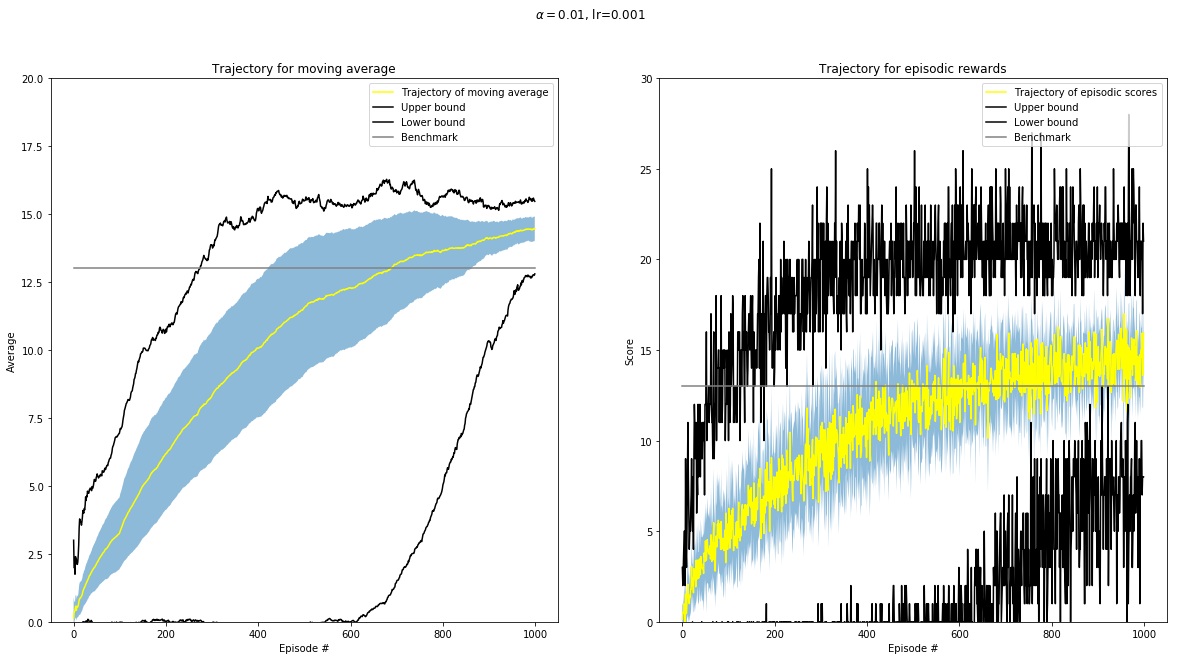

In [23]:
plot_result(scores, means, r'$\alpha=0.01$, lr=0.001')

## $\alpha=0.02$

In [34]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.02, learning_rate=0.0001)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 3.00	Average Score: 2.90
Episode 200	Episodic Score: 16.00	Average Score: 9.56
Episode 300	Episodic Score: 12.00	Average Score: 14.10
Episode 400	Episodic Score: 13.00	Average Score: 15.46
Episode 500	Episodic Score: 13.00	Average Score: 16.24
Episode 600	Episodic Score: 11.00	Average Score: 15.42
Episode 700	Episodic Score: 16.00	Average Score: 16.39
Episode 800	Episodic Score: 15.00	Average Score: 16.09
Episode 900	Episodic Score: 17.00	Average Score: 16.75
Episode 1000	Episodic Score: 15.00	Average Score: 16.73
Test No.2:
Episode 100	Episodic Score: 12.00	Average Score: 3.78
Episode 200	Episodic Score: 17.00	Average Score: 8.84
Episode 300	Episodic Score: 19.00	Average Score: 13.42
Episode 400	Episodic Score: 14.00	Average Score: 15.11
Episode 500	Episodic Score: 12.00	Average Score: 16.26
Episode 600	Episodic Score: 16.00	Average Score: 16.06
Episode 700	Episodic Score: 17.00	Average Score: 16.52
Episode 800	Episodic Score: 16.00	Average Score

Episode 700	Episodic Score: 15.00	Average Score: 16.20
Episode 800	Episodic Score: 19.00	Average Score: 16.76
Episode 900	Episodic Score: 18.00	Average Score: 16.92
Episode 1000	Episodic Score: 13.00	Average Score: 15.89


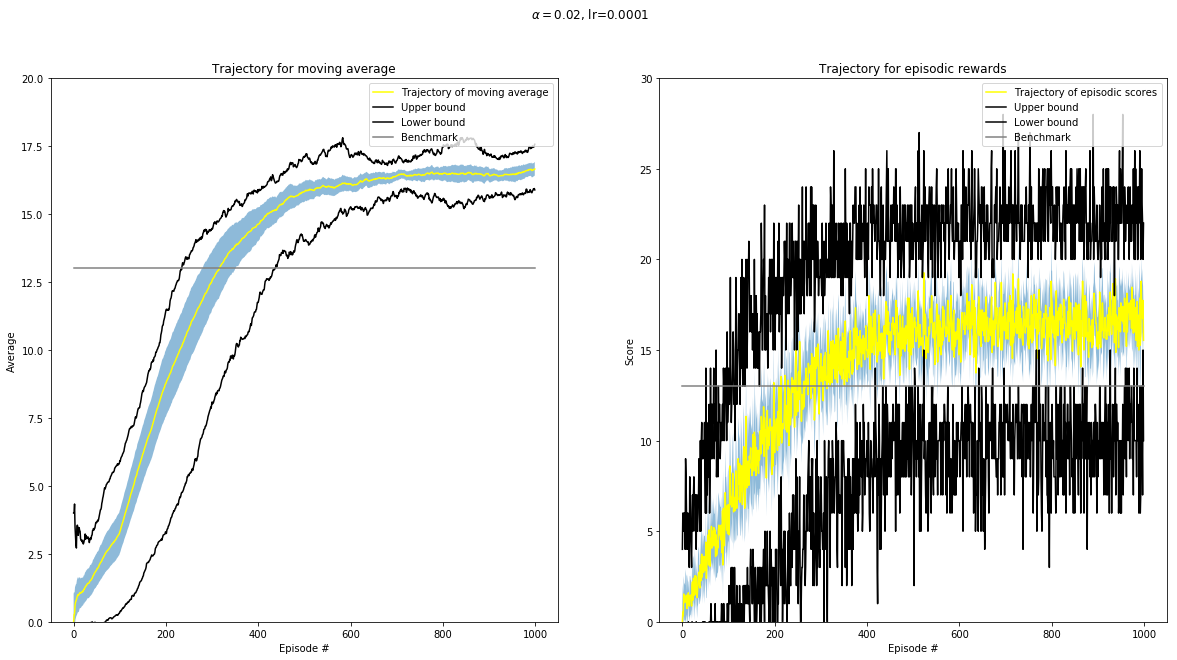

In [35]:
plot_result(scores, means, r'$\alpha=0.02$, lr=0.0001')

In [8]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.02, learning_rate=0.0005)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: 1.00	Average Score: 3.57
Episode 200	Episodic Score: 9.00	Average Score: 7.123
Episode 300	Episodic Score: 6.00	Average Score: 10.981
Episode 400	Episodic Score: 8.00	Average Score: 11.875
Episode 500	Episodic Score: 13.00	Average Score: 12.62
Episode 600	Episodic Score: 13.00	Average Score: 12.24
Episode 700	Episodic Score: 4.00	Average Score: 11.887
Episode 800	Episodic Score: 13.00	Average Score: 12.15
Episode 900	Episodic Score: 16.00	Average Score: 11.92
Episode 1000	Episodic Score: 10.00	Average Score: 11.25
Test No.2:
Episode 100	Episodic Score: 5.00	Average Score: 4.92
Episode 200	Episodic Score: 1.00	Average Score: 8.859
Episode 300	Episodic Score: 16.00	Average Score: 11.41
Episode 400	Episodic Score: 8.00	Average Score: 14.020
Episode 500	Episodic Score: 16.00	Average Score: 14.72
Episode 600	Episodic Score: 17.00	Average Score: 15.23
Episode 700	Episodic Score: 14.00	Average Score: 14.22
Episode 800	Episodic Score: 9.00	Average Score: 

Episode 700	Episodic Score: 16.00	Average Score: 14.48
Episode 800	Episodic Score: 17.00	Average Score: 15.73
Episode 900	Episodic Score: 15.00	Average Score: 15.34
Episode 1000	Episodic Score: 16.00	Average Score: 15.08


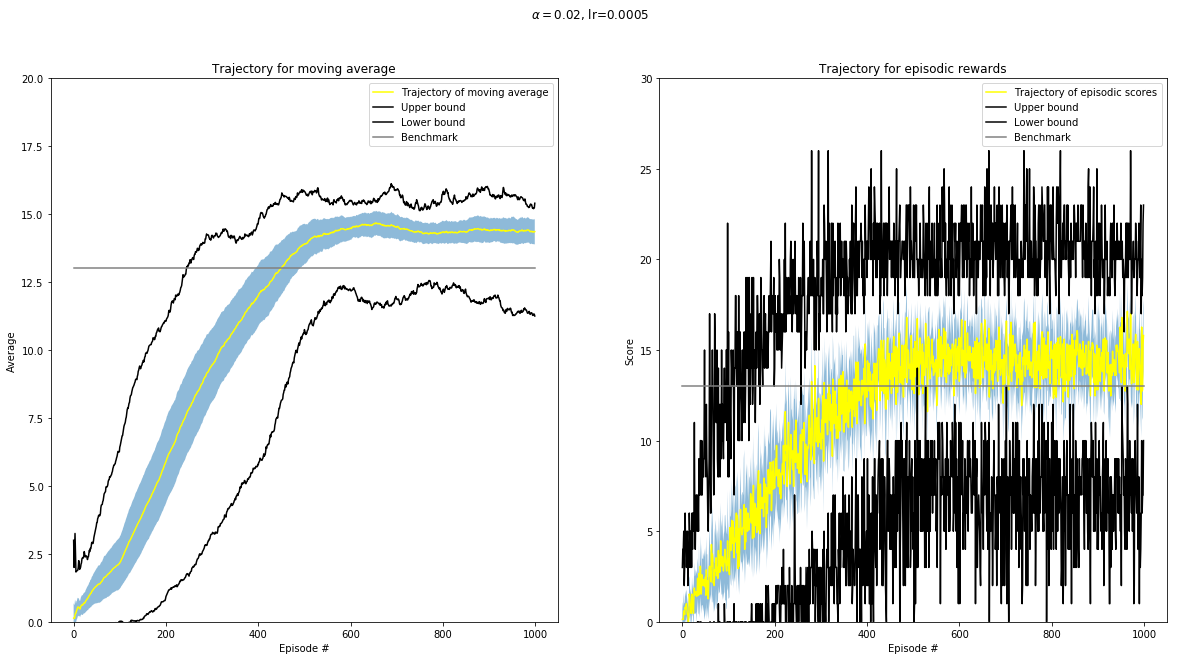

In [9]:
plot_result(scores, means, r'$\alpha=0.02$, lr=0.0005')

## $\alpha=0.1$

In [16]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size, action_size, alpha=0.1, learning_rate=0.0001)
    scores[i,:], means[i,:] = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Test No.1:
Episode 100	Episodic Score: -2.00	Average Score: 0.15
Episode 200	Episodic Score: 3.00	Average Score: 1.805
Episode 300	Episodic Score: 0.00	Average Score: 3.331
Episode 400	Episodic Score: 4.00	Average Score: 5.182
Episode 500	Episodic Score: 5.00	Average Score: 5.832
Episode 600	Episodic Score: 7.00	Average Score: 5.846
Episode 700	Episodic Score: 2.00	Average Score: 5.785
Episode 800	Episodic Score: 9.00	Average Score: 5.770
Episode 900	Episodic Score: 8.00	Average Score: 6.191
Episode 1000	Episodic Score: 5.00	Average Score: 5.78
Test No.2:
Episode 100	Episodic Score: 1.00	Average Score: 0.428
Episode 200	Episodic Score: 4.00	Average Score: 2.327
Episode 300	Episodic Score: 7.00	Average Score: 4.069
Episode 400	Episodic Score: 3.00	Average Score: 4.976
Episode 500	Episodic Score: 3.00	Average Score: 5.379
Episode 600	Episodic Score: 3.00	Average Score: 5.974
Episode 700	Episodic Score: 8.00	Average Score: 5.698
Episode 800	Episodic Score: 6.00	Average Score: 5.687
Episod

Episode 900	Episodic Score: 6.00	Average Score: 6.534
Episode 1000	Episodic Score: 9.00	Average Score: 5.99


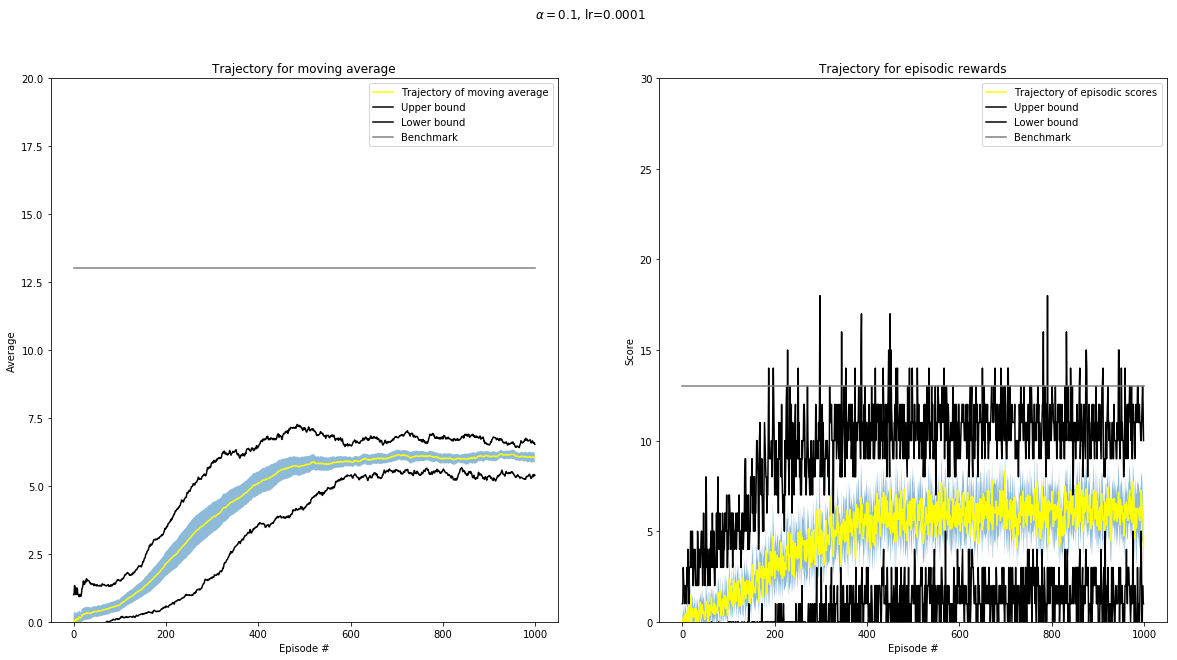

In [17]:
plot_result(scores, means, r'$\alpha=0.1$, lr=0.0001')

In [18]:
env.close()

## Some conclusion

  * This algorithm is sensitive to the choice of $\alpha$. 
      * If it's too small, a little difference in Q-values will lead to unbeatable advantage in the probability, which hurts exploration and prevents the agent from learning anything meaningful. This can be seen from the lower bound of $\alpha=0.01$
      * If it's too large, the true reward signals from environment will play a less important role, which directly harms the final performance. Although under this circumstance the training is stable. See the performance when $\alpha=0.1$
      * Compared to DQN, 